In [ ]:
# Imports 
from __future__ import absolute_import, division, print_function, unicode_literals
%matplotlib inline
# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io 
import os


# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Dropout, Flatten

from keras import backend as K #not sure what this does

# Libraries for Data Preprocessing and Analysis
import nltk


nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_recall_curve,f1_score,auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer

import numpy as np
from numpy.testing import assert_allclose
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import ModelCheckpoint

import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.models
from keras.models import model_from_json

import shutil

# Libraries for other Classifiers 
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, naive_bayes, svm
from sklearn.svm import SVC


#Mount drive to import files 
from google.colab import drive
drive.mount('/content/gdrive')

print(tf.__version__)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Mounted at /content/gdrive
2.3.0


#Data Preprocessing: Import data, trim, split, encode vectorize, embed


In [ ]:
# Read in to Pandas DataFrame and drop the first row(which contained column names as I have assigned new names)
from google.colab import files

reviews = pd.read_csv(r"/content/gdrive/MyDrive/ColabNotebooks/rt_reviews.csv",encoding = 'latin-1', names = ['target','review'])
reviews = reviews.iloc[1:]
#reviews = reviews.iloc[:2048]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Transform targets as an error occured at some point
count_pos = 0
count_neg = 0
# Standardize target data types to numeric
for i in range(reviews.shape[0]):
    if(reviews['target'].values[i] == '0'):
        reviews['target'].values[i] = 0
    elif(reviews['target'].values[i] == '1'):
        reviews['target'].values[i] = 1
    if(reviews['target'].values[i] == 0): 
      count_pos += 1 
    if(reviews['target'].values[i]==1):
      count_neg += 1
for i in range(reviews.shape[0]):
    if(isinstance(reviews['target'].values[i],str)):
        print("Caught: ",reviews['target'].values[i])
    if(reviews['target'].values[i] != 0 and reviews['target'].values[i] != 1):
        print("Error")

# Split is 50/50
print(count_pos)
print(count_neg)

240000
240000


In [ ]:
#Transfer to lowercase 
reviews['review'] = [entry.lower() for entry in reviews['review']]

In [ ]:
# Split data into train test validation. Using an 80/10/10 split 
test_s = .2
train_x, test_x, train_y, test_y = model_selection.train_test_split(reviews['review'], 
                                                                    reviews['target'], test_size=test_s, random_state = 42)

test_x, val_x, test_y, val_y = model_selection.train_test_split(test_x, test_y, test_size=.5,random_state = 42)

# Encode target data
Encoder = LabelEncoder()
train_y = Encoder.fit_transform(train_y)
test_y = Encoder.fit_transform(test_y)
val_y = Encoder.fit_transform(val_y)

# Fit tokenizer to training data and tokenize data and transform to numeric data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x)
X_train = tokenizer.texts_to_sequences(train_x)
X_test = tokenizer.texts_to_sequences(test_x)
X_val = tokenizer.texts_to_sequences(val_x)

# Get vocab size from tokenizer 
vocab_size = len(tokenizer.word_index) + 1

#Specify the maximum length that any word can be
maxlen = 400

# Pad sequences to allow for very long and very short reviews
X_train = pad_sequences(X_train, padding = 'post', maxlen = maxlen)
X_test = pad_sequences(X_test, padding = 'post', maxlen = maxlen)
X_val = pad_sequences(X_val, padding ='post', maxlen = maxlen)



In [ ]:
# Verify data by printing out shapes of data 
print(vocab_size)
print(X_test.shape)
print(X_val.shape)
print(X_train.shape)
print(train_y)

95805
(48000, 400)
(48000, 400)
(384000, 400)
[1 1 0 ... 0 1 0]


In [ ]:
# Import embedding Glove weights and create embedding matrix
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with io.open(filepath, encoding = 'utf8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix
embedding_dim = 300 # cannot exceed glove size dimensions
embedding_matrix = create_embedding_matrix('/content/gdrive/MyDrive/ColabNotebooks/glove.6B.300d.txt',tokenizer.word_index, embedding_dim)

In [ ]:
#Best Architecture: Least Complex: This was our final architecture although many were tried
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen,
                           trainable=True))
model.add(layers.Conv1D(256, 5, activation = 'relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dense(1, activation =  'sigmoid'))
model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          9580500   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 196, 256)          128256    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                4112      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 9,712,885
Trainable params: 9,712,885
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Create ModelCheckpoint to save weights during fitting 
checkpoint_path = "gdrive/MyDrive/ColabNotebooks/training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
# Create a callback that saved models weights 
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                 save_weights_only = True,
                                                 verbose = 1)

#Train the mdoel with the new callback
history = model.fit(X_train,
          train_y,
          epochs = 5,
          verbose = True,
          batch_size = 1024,
          validation_data =(X_val, val_y),
          callbacks=[cp_callback])

!ls {checkpoint_dir}



Epoch 1/5
375/375 [==============================] - 103s 274ms/step - loss: 0.4702 - accuracy: 0.7695 - val_loss: 0.3892 - val_accuracy: 0.8233
Epoch 2/5
375/375 [==============================] - 99s 265ms/step - loss: 0.3321 - accuracy: 0.8573 - val_loss: 0.3389 - val_accuracy: 0.8542
Epoch 3/5
375/375 [==============================] - 98s 261ms/step - loss: 0.2527 - accuracy: 0.8991 - val_loss: 0.3163 - val_accuracy: 0.8706
Epoch 4/5
375/375 [==============================] - 100s 267ms/step - loss: 0.1851 - accuracy: 0.9311 - val_loss: 0.3144 - val_accuracy: 0.8795
Epoch 5/5
375/375 [==============================] - 99s 265ms/step - loss: 0.1285 - accuracy: 0.9559 - val_loss: 0.3342 - val_accuracy: 0.8848


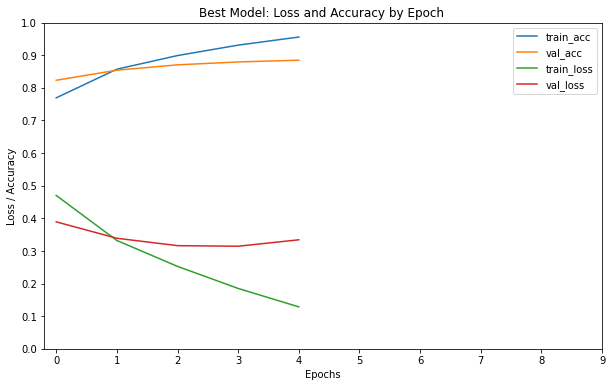

In [ ]:
#Graph results over epochs
history = model.fit(X_train,
          train_y,
          epochs = 10,
          verbose = True,
          batch_size = 1024,
          validation_data =(X_val, val_y))

# Plots of Loss or Accuracy of various models
fig, (ax1) = plt.subplots(1,1, figsize = (10,6), sharey = 'row')
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title("Best Model: Loss and Accuracy by Epoch ")
ax1.set_ylabel("Loss / Accuracy")
ax1.set_xlabel("Epochs")


ax1.legend(['train_acc','val_acc', 'train_loss', 'val_loss'], loc = 'best')
plt.yticks(np.arange(0, 1.1, .1))
plt.xticks(np.arange(0, 10, 1.0))
plt.show()


In [ ]:

 # Load tokenizer for preprocessing
with open('gdrive/MyDrive/ColabNotebooks/tokenizer.pickle', 'rb') as handle: 
    tokenizer = pickle.load(handle)
  
  # Load model into memory
json_file = open('gdrive/MyDrive/ColabNotebooks/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Load weights into model
loaded_model.load_weights("gdrive/MyDrive/ColabNotebooks/model.h5")


# Convert text to array 
sampleArray = [sample]

sampleTokenized = tokenizer.texts_to_sequences(sampleArray)
samplePadded = pad_sequences(sampleTokenized, padding = 'post', maxlen = 400)

loaded_model.compile(optimizer="adam",loss='binary_crossentropy',metrics=['accuracy'])


219/219 [==============================] - 3s 12ms/step - loss: 0.3921 - accuracy: 0.8976
Accuracy of Test data: 0.9


In [ ]:
# Final test of data 
# Test accuracy of a model
loss, acc = loaded_model.evaluate(X_test,test_y)
print("Accuracy of Test data: {}".format(round(acc,2)))

In [ ]:
# Save tokenizer and model for later demo use of training 

# Pickle tokenizer 
with open('gdrive/MyDrive/ColabNotebooks/tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol = pickle.HIGHEST_PROTOCOL)

#Serialize model to JSON 
model_json = model.to_json()
with open("gdrive/MyDrive/ColabNotebooks/model.json", "w") as json_file:
  json_file.write(model_json)

model1.save_weights("gdrive/MyDrive/ColabNotebooks/model.h5")


In [ ]:
# Final model attempted, left in to show how multiple models were tested and saved.
# About 30 models tested total 
model3 = Sequential()
model3.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen,
                           trainable=True))
model3.add(layers.Conv1D(256,5, activation = 'relu'))
model3.add(layers.BatchNormalization())
model3.add(layers.Dropout(.2))
model3.add(layers.GlobalMaxPooling1D()) 
model3.add(layers.Dense(16, activation = 'relu'))
model3.add(layers.BatchNormalization())
model3.add(layers.Dropout(.2))
model3.add(layers.Dense(1, activation =  'sigmoid'))
model3.summary()
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 400, 300)          28741500  
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 396, 16)           24016     
_________________________________________________________________
dropout_12 (Dropout)         (None, 396, 16)           0         
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 16)                0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_32 (Dense)             (None, 1)               

In [ ]:
# Create ModelCheckpoint for different model 
checkpoint_path = "gdrive/MyDrive/ColabNotebooks/advanced_model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
# Create a callback that saved models weights 
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                 save_weights_only = True,
                                                 verbose = 1)
 
# Train the mdoel with the new callback
history3 = model3.fit(X_train,
          train_y,
          epochs = 8,
          verbose = True,
          batch_size = 1024,
          validation_data =(X_val, val_y),
          callbacks=[cp_callback])

!ls {checkpoint_dir} 

In [ ]:
# Model to predict a single sample for demo. Takes in string, processed data, loads saved model, weights, tokenizer, predicts data, returns result 
def predictExample(sample): 

  # Load tokenizer for preprocessing
  with open('gdrive/MyDrive/ColabNotebooks/tokenizer.pickle', 'rb') as handle: 
    tokenizer = pickle.load(handle)
  
  # Load model into memory
  json_file = open('gdrive/MyDrive/ColabNotebooks/model.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)

  # Load weights into model
  loaded_model.load_weights("gdrive/MyDrive/ColabNotebooks/model.h5")


  # Convert text to array 
  sampleArray = [sample]

  sampleTokenized = tokenizer.texts_to_sequences(sampleArray)
  samplePadded = pad_sequences(sampleTokenized, padding = 'post', maxlen = 400)

  loaded_model.compile(optimizer="adam",loss='binary_crossentropy',metrics=['accuracy'])

  result = np.asscalar(loaded_model.predict(samplePadded))
  
  if result >=.65:
    print("\nThis texts sentiment is positive\n")
  
  elif result <.65 and result >.35: 
    if result >.5:
      print("\nNot confident about result but leaning slightly towards positive\n")
    else:
      print("\nNot confident about result but leaning slightly towards negative\n")
  elif result <=.35:
    print("\nThis texts sentiment is negative\n")

  else:
    print("\nThere was an error\n")
    return 0

  print("{}\n\n".format(round(result,4)))
  return result


In [ ]:
#Movie review 
sampleNeg = """
 Sharknado 23 was a so/so movie, it could have used double the sharks and half the tornados
"""
predictExample(sampleNeg)

samplePos = """
 Sharknado 23 was an amazing movie, sharks are very scary
"""
predictExample(samplePos)


This texts sentiment is negative

0.0034




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead



This texts sentiment is positive

0.9018




0.9017947912216187

In [ ]:
# Our project review
sample = """
Pos: Great baseline results. 
Very detailed report, great job! 
Also, I appreciate the detailed algorithmic results. 
Good next steps planning. 
Recommnedations: If the team has time, you might try using a neural network. 
Typically deep learning yields state-of-the-art performance on NLP tasks. 
And if training is taking a long time, consider using external computing power (Google colab GPUs are free).
"""

predictExample(sample)



This texts sentiment is positive

0.9948




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


0.9947527647018433

In [ ]:
#Review of a possible fraud
sample = """ 
Not impressed by slob @AlbertEinstein. Failed patent clerk, might've stolen theory
of relativity, ppl I've talked to say so. Investigation underway, very suspicious
"""
predictExample(sample)


This texts sentiment is negative

0.0017




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


0.0017213523387908936

In [ ]:
#Class generated review
sample = """
Once Upon A Time In Anatolia - dir. Nuri Bilge Ceylan, 2011. ***** Slowly developing but brilliantly told story of a search for a body following a homicide. Ceylan is able to transform this into a set piece of tremendous impact.
"""
predictExample(sample)


This texts sentiment is positive

1.0




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


0.9999978542327881

In [ ]:
# Visualize data  
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

feat_cols = [ 'pixel'+str(i) for i in range(X_train.shape[1]) ]
df = pd.DataFrame(X_train,columns=feat_cols)
df['y'] = train_y
df['label'] = df['y'].apply(lambda i: str(i))
X, y = None, None
rndperm = np.random.permutation(df.shape[0])

sc = StandardScaler()
#xtr = sc.fit_transform(X_train)
xtr = X_train
pca = PCA(n_components = 3)
xtr = pca.fit_transform(xtr)

df['pca-one'] = xtr[:,0]
df['pca-two'] = xtr[:,1]
df['pca-three'] = xtr[:,2]


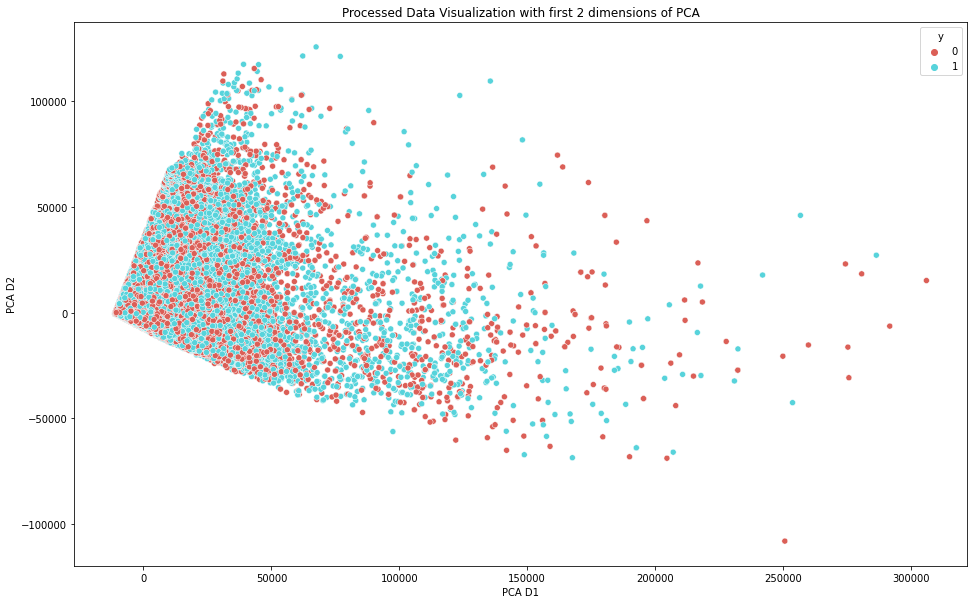

In [ ]:
# Plot data in 2D
plt.figure(figsize=(16,10))
ax = plt.axes()
sns.scatterplot(
    x = df['pca-one'], y = df['pca-two'],
    hue = 'y',
    palette = sns.color_palette("hls", 2),
    data = df.loc[rndperm,:],
    legend = "full",
    alpha = 1)
ax.set_title('Processed Data Visualization with first 2 dimensions of PCA')
ax.set_ylabel('PCA D2')
ax.set_xlabel('PCA D1')
plt.show()

In [ ]:
#Plot data in 3D
color = ['red', 'blue']
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    c=df.loc[rndperm,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('PCA D1')
ax.set_ylabel('PCA D2')
ax.set_zlabel('PCA D3')
ax.set_title = 'Processed Data Visualization with first 2 dimensions of PCA'
plt.show()